# Estimate Depth with Stereo Camera

## In this code, 
- Using stereo camera images, We estimate objects depth and create 4D (=3D + time) videos.
    - top image = RGB + object detection + depth
    - middle image = Depth Maps
    - bottom image = 3d point cloud

![4D Perception-1](./output/stereo_4d_perception_2011_10_03_drive_0027.gif)


## Preparation
1. Download

    https://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d

2. Caputre 20 ro more charuco board images.

## This code steps
1. EDA of KITTI dataset
2. Calculate Disparity Maps
3. Calculate Depth Maps
4. Get the depth of objects
5. 3D Reconstruction
6. Video Depth Estimation

## Data
- I used KITTI dataset.

In [1]:
from glob import glob
import numpy as np
import sys, os, cv2, inspect
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from ipywidgets import interact, interactive, fixed

In [2]:
!ls -lh ./KITTI/object/training/

total 956K
drwxrwxr-x 2 takuya takuya 224K Jun  1  2012 calib
drwxrwxr-x 2 takuya takuya 236K Jun  1  2012 image_2
drwxrwxr-x 2 takuya takuya 256K Jun  1  2012 image_3
drwxrwxr-x 2 takuya takuya 224K May 21  2015 label_2


In [3]:
# object
top_dir_object = './KITTI/object/training'
file_paths_img_left = sorted(glob(f'{top_dir_object}/image_2/*.png'))
file_paths_img_right = sorted(glob(f'{top_dir_object}/image_3/*.png'))

print(f'image_num_left = {len(file_paths_img_left)}')
print(f'image_num_right = {len(file_paths_img_right)}')

image_num_left = 7481
image_num_right = 7481


## 1. EDA of KITTI dataset

### 1.1. Visualize left and right images
- These images are already rectified, and there are depth ground truth.

file_ids = [3155, 6209, 6917]


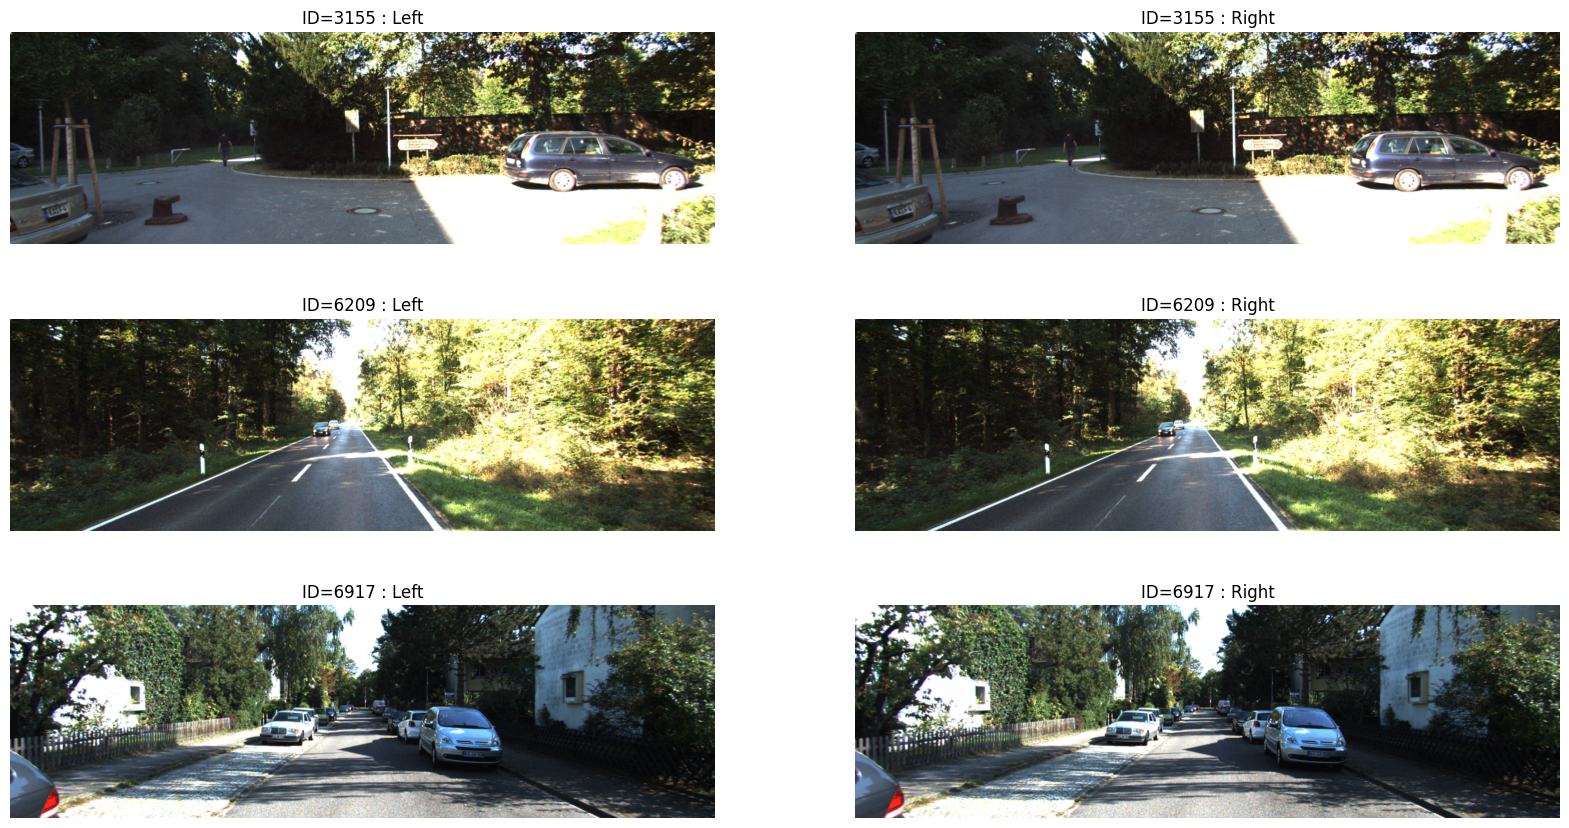

In [4]:
import random
random.seed(0)
image_num = 3
file_ids = sorted(random.sample(range(0, len(file_paths_img_left)-1), image_num))

print(f'file_ids = {file_ids}')

plt.figure(figsize=(20,18))

for i, file_id in enumerate(file_ids):    
    # laod image
    img_left = cv2.imread(file_paths_img_left[file_id])
    img_right = cv2.imread(file_paths_img_right[file_id])
    
    # transform bgr to rgb
    img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
    img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
    
    # show images
    plt.subplot(5,2,2*i+1)
    plt.imshow(img_left)
    plt.title(f'ID={file_id} : Left')
    plt.axis('off')
    
    plt.subplot(5,2,2*i+2)
    plt.imshow(img_left)
    plt.title(f'ID={file_id} : Right')
    plt.grid()
    plt.axis('off')
    

### 1.2. Read a KITTI calibration parameters

In [5]:
def printDict(dict):
    for key, value in dict.items():
        print(f'\n{key} = ')
        print(f'{value}')

In [6]:
from stereo_camera_utility import readObjectCalibFile
calib_params = readObjectCalibFile(f'{top_dir_object}/calib/000000.txt')
printDict(calib_params)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.

P0 = 
[[707.0493   0.     604.0814   0.    ]
 [  0.     707.0493 180.5066   0.    ]
 [  0.       0.       1.       0.    ]]

P1 = 
[[ 707.0493    0.      604.0814 -379.7842]
 [   0.      707.0493  180.5066    0.    ]
 [   0.        0.        1.        0.    ]]

P2 = 
[[ 7.070493e+02  0.000000e+00  6.040814e+02  4.575831e+01]
 [ 0.000000e+00  7.070493e+02  1.805066e+02 -3.454157e-01]
 [ 0.000000e+00  0.000000e+00  1.000000e+00  4.981016e-03]]

P3 = 
[[ 7.070493e+02  0.000000e+00  6.040814e+02 -3.341081e+02]
 [ 0.000000e+00  7.070493e+02  1.805066e+02  2.330660e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00  3.201153e-03]]

R0_rect = 
[[ 0.9999128   0.01009263 -0.00851193]
 [-0.01012729  0.9999406  -0.00403767]
 [ 0.00847068  0.00412352  0.9999556 ]]

Tr_velo_to_cam = 
[[ 0.00692796 -0.9999722  -0.00275783 -0.02457729]

### 1.3. Get Intrinsic and Extrinsic Matrix from Projection Matrix

In [7]:
K_left, R_left, t_left, _, _, _, _ = cv2.decomposeProjectionMatrix(calib_params['P2'])
t_left /= t_left[3]
print(f'K_left = \n{K_left}\n')
print(f'R_left = \n{R_left}\n')
print(f't_left = \n{t_left}\n')

K_left = 
[[707.0493   0.     604.0814]
 [  0.     707.0493 180.5066]
 [  0.       0.       1.    ]]

R_left = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

t_left = 
[[-0.06046166]
 [ 0.00176016]
 [-0.00498102]
 [ 1.        ]]



In [8]:
K_right, R_right, t_right, _, _, _, _ = cv2.decomposeProjectionMatrix(calib_params['P3'])
t_right /= t_right[3]
print(f'K_right = \n{K_right}\n')
print(f'R_right = \n{R_right}\n')
print(f't_right = \n{t_right}\n')

K_right = 
[[707.0493   0.     604.0814]
 [  0.     707.0493 180.5066]
 [  0.       0.       1.    ]]

R_right = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

t_right = 
[[ 0.47527359]
 [-0.00247908]
 [-0.00320115]
 [ 1.        ]]



### 1.4. Get F (= Fundamental Matrix) to calculate epipolar lines

In [9]:
t_rel = t_right - t_left
t_rel = t_rel.flatten()
print(f't_rel = {t_rel}')

T_x = np.array([
    [0, -t_rel[2], t_rel[1]],
    [t_rel[2], 0, -t_rel[0]],
    [-t_rel[1], t_rel[0], 0]
])

F = np.linalg.inv(K_right).T @ T_x @ R_right @ np.linalg.inv(K_left)
print(f'F = {F}')


t_rel = [ 0.53573524 -0.00423924  0.00177986  0.        ]
F = [[ 0.00000000e+00 -3.56030482e-09 -5.35302167e-06]
 [ 3.56030482e-09  0.00000000e+00 -7.59856353e-04]
 [ 5.35302167e-06  7.59856353e-04  0.00000000e+00]]


### 1.5. Calculate Epipolar lines of KITTI dataset
- The inclination of epipolar lines of KITTI is about 0.007.
- So, we do not need to calibrate these files.

line: ax+by+c = 0 // average of -a/b = -0.00742


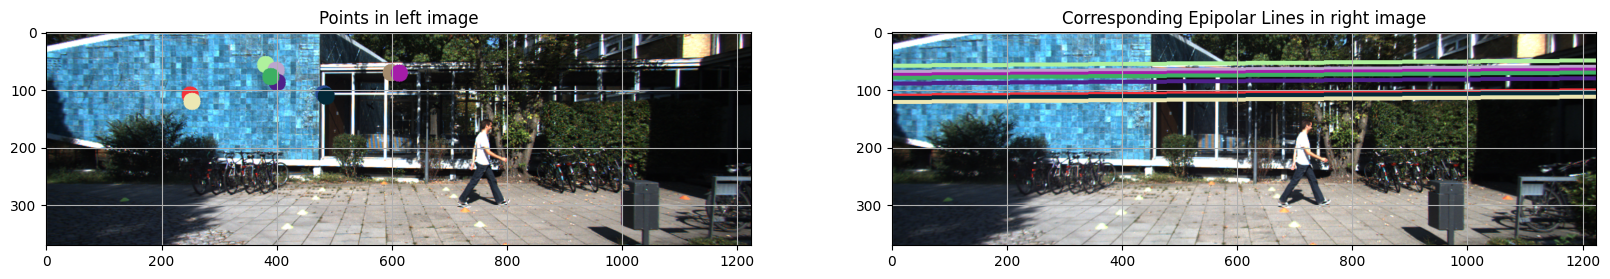

In [10]:
from stereo_camera_utility import drawEpipolarLines

file_id = 0
img_left_bgr = cv2.imread(file_paths_img_left[file_id])
img_right_bgr = cv2.imread(file_paths_img_right[file_id])

img_left_rgb = cv2.cvtColor(img_left_bgr, cv2.COLOR_BGR2RGB)
img_right_rgb = cv2.cvtColor(img_right_bgr, cv2.COLOR_BGR2RGB)

drawEpipolarLines(img_right_bgr.copy(), img_left_bgr.copy(), F, top_k=10)

line: ax+by+c = 0 // average of -a/b = -0.00714


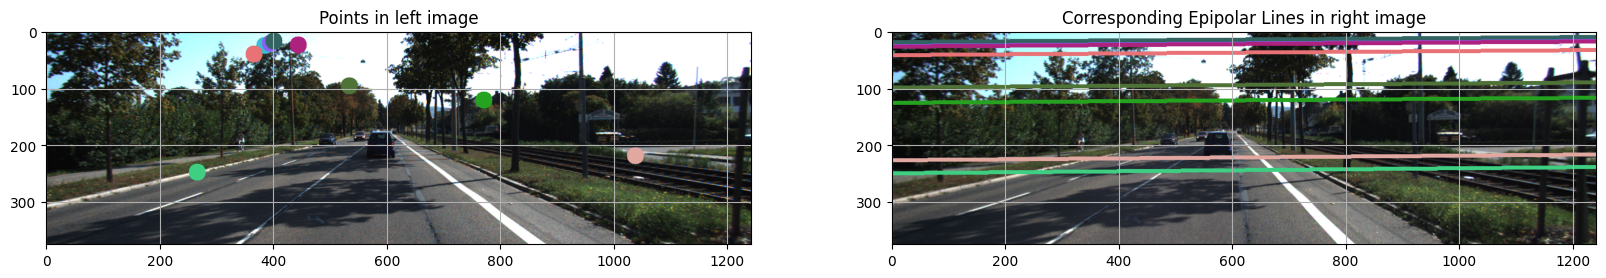

In [11]:
file_id = 7
img_left_bgr = cv2.imread(file_paths_img_left[file_id])
img_right_bgr = cv2.imread(file_paths_img_right[file_id])

img_left_rgb = cv2.cvtColor(img_left_bgr, cv2.COLOR_BGR2RGB)
img_right_rgb = cv2.cvtColor(img_right_bgr, cv2.COLOR_BGR2RGB)

drawEpipolarLines(img_right_bgr.copy(), img_left_bgr.copy(), F, top_k=10)

## 2. Calculate Disparity Maps

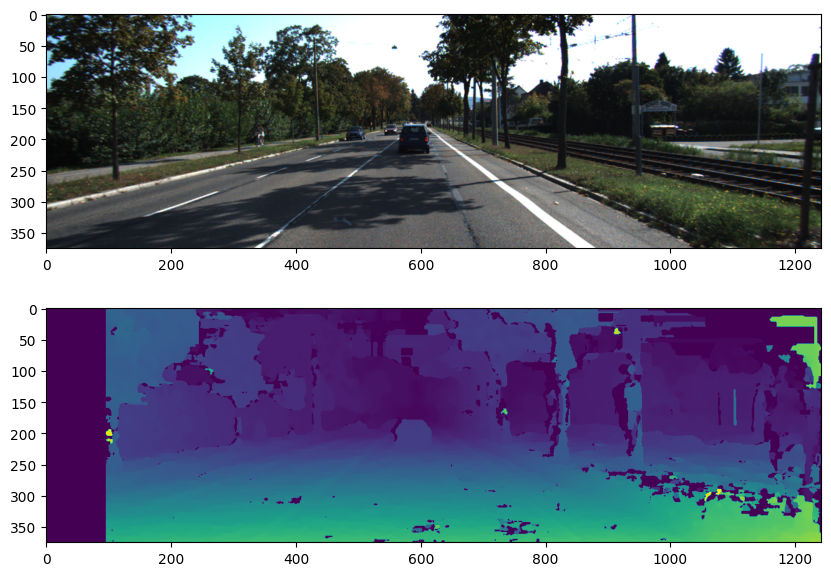

In [12]:
from stereo_camera_utility import calcDisparity

disparity_map = calcDisparity(img_left_bgr, 
                              img_right_bgr, 
                              matcher="stereo_sgbm", 
                              num_disparities=6*16,  # 16*13, 
                              block_size=11,  # 9, 
                              window_size=6  # 9
                              )

plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.imshow(img_left_rgb)

plt.subplot(2,1,2)
plt.imshow(disparity_map)

## 3. Calculate Depth Map

$
Z = \frac{f \cdot b}{x_L - x_R} = \frac{f \cdot b}{disparity}
$

- f = focal length
- b = baseline

In [13]:
def calcDepthMap(disparity_left, focal_length, baseline):
    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disparity_left[disparity_left==0] = 0.1
    disparity_left[disparity_left==-1] = 0.1
    
    # Initialize the depth map to match the size of the disparity map
    depth_map = np.ones(disparity_left.shape, np.single)
    
    # Calculate disparity map
    depth_map[:] = focal_length * baseline / disparity_left[:]
    
    return depth_map

Text(0.5, 1.0, 'Depth Map')

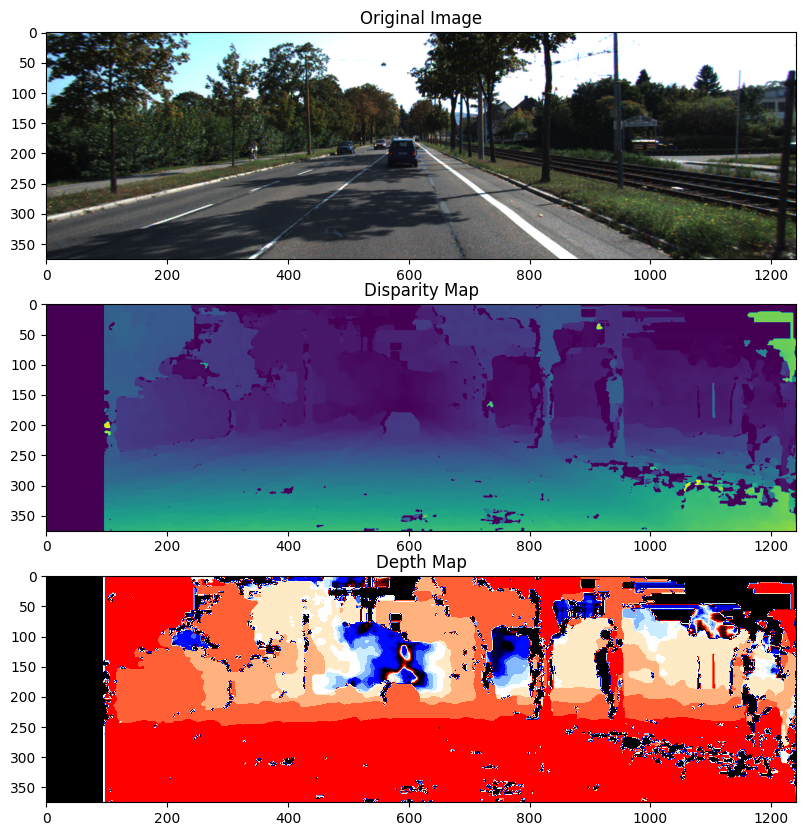

In [14]:
# focal length
focal_length = K_left[0,0]

# baseline
baseline = abs(t_left[0] - t_right[0])
    
depth_map_left = calcDepthMap(disparity_map, focal_length, baseline)

fig, axes = plt.subplots(3,1, figsize=(10,10))

axes[0].imshow(img_left_rgb)
axes[0].set_title('Original Image')

axes[1].imshow(disparity_map)
axes[1].set_title('Disparity Map')

axes[2].imshow(depth_map_left, cmap='flag')
axes[2].set_title('Depth Map')

## 4. Get the depth (= distance ) of Objects

### 4.1. Find the Object Bounding Boxes with YOLO

In [15]:
#!sudo pip install ultralytics #packages installed for me: ultralytics-8.3.51 ultralytics-thop-2.0.13

In [16]:
#!wget https://stereo-vision.s3.eu-west-3.amazonaws.com/yolo11n.pt  #download yolo11n.pt
#!mv ./yolo11n.pt ./models/

In [17]:
import ultralytics
from ultralytics import YOLO
import time
import torch

# load a model
model = YOLO('./models/yolo11n.pt')

print(model.overrides) 
print("Ultralytics version:", ultralytics.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/takuya/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
{'task': 'detect', 'data': '/usr/src/ultralytics/ultralytics/cfg/datasets/coco.yaml', 'imgsz': 640, 'single_cls': False, 'model': './models/yolo11n.pt'}
Ultralytics version: 8.3.171


In [18]:
# Try using GPU
try:
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model.to(device)
except RuntimeError as e:
    device = 'cpu'
    model.to(device)
finally:
    print(f'device = {device}')

device = cuda:0


In [19]:
def detectObstacles(img, model, device):
    h, w, _ = img.shape
    results = model.predict(img, device=device, verbose=False)
    result = results[0]  # get prediction result for the first image.
    boxes = result.boxes  # Boxes object for bounding box outputs
    # masks = result.masks  # Masks object for segmentation masks outputs
    # keypoints = result.keypoints  # Keypoints object for pose outputs
    # probs = result.probs  # Probs object for classification outputs
    # obb = result.obb # Oriented boxes object for OBB outputs
    
    # Get person or car
    boxes_filter = []
    for box in boxes:
        object_type = result.names[int(box.cls[0])]
        if object_type=='person' or object_type=='car':
            boxes_filter.append(True)
        else:
            boxes_filter.append(False)
            
    pred_classes = []
    for label in boxes.cls[boxes_filter]:
        pred_classes.append(result.names[int(label)])
        
    # xywhn: 各バウンディングボックスを [center_x, center_y, width, height] 形式で 
    # 画像サイズで割った正規化値として返します
    pred_bboxes = boxes.xywhn[boxes_filter]
    pred_bboxes[:, 0] *= w # ratio to pixel
    pred_bboxes[:, 1] *= h # ratio to pixel
    pred_bboxes[:, 2] *= w # ratio to pixel
    pred_bboxes[:, 3] *= h # ratio to pixel
    pred_conf = boxes.conf[boxes_filter]
    return pred_bboxes, pred_classes, pred_conf

print(f'img_left_rgb.shape = {img_left_rgb.shape}')

pred_bboxes, pred_classes, pred_conf = detectObstacles(img_left_bgr, model, device)

img_left_rgb.shape = (375, 1242, 3)


In [20]:
print(f'pred_bboxes = \n{pred_bboxes}\n')
print(f'pred_classes = \n{pred_classes}\n')
print(f'pred_conf = \n{pred_conf}\n')

pred_bboxes = 
tensor([[589.9032, 197.7618,  50.3762,  50.2707],
        [553.4805, 184.4307,  25.5198,  18.8808],
        [497.2751, 192.1904,  31.1200,  21.1193]], device='cuda:0')

pred_classes = 
['car', 'car', 'car']

pred_conf = 
tensor([0.5979, 0.5801, 0.4626], device='cuda:0')



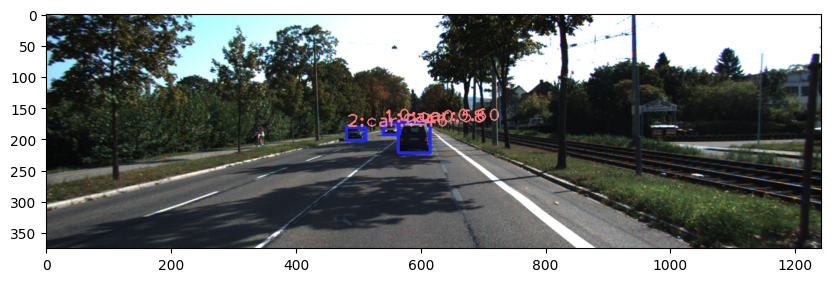

In [21]:
def drawDetectedObstacles(pred_bboxes, pred_classes, pred_conf, img_ori):
    rectangle_thickness = 3
    text_thickness = 2
    img = img_ori.copy()
    h, w, _ = img.shape
    counter = 0
    for box, cls, conf in zip(pred_bboxes, pred_classes, pred_conf):
        x1 = int(box[0] - box[2]*0.5) # left : center_x - width /2
        y1 = int(box[1] - box[3]*0.5) # top : center_y - height /2
        x2 = int(box[0] + box[2]*0.5) # right : center_x + width/2
        y2 = int(box[1] + box[3]*0.5) # bottom : center_y + height/2
        objecttype = cls
        
        if objecttype=='person' or objecttype=='car':
            cv2.rectangle(img, (x1,y1),
                          (x2,y2), (30, 40, 255), rectangle_thickness)
            
            # 変換を修正
            #confidence = conf.numpy().round(2)
            confidence = conf.cpu().numpy().round(2)
            
            cv2.putText(img, 
                        f"{counter}:{objecttype}:{confidence:.2f}",
                        (x1, y1),
                        cv2.FONT_HERSHEY_PLAIN, 
                        fontScale=2, 
                        color=(255, 125, 125), 
                        thickness=text_thickness)
            counter +=1
    return img

img_with_prediction = drawDetectedObstacles(pred_bboxes, pred_classes, pred_conf, img_left_rgb)

plt.figure(figsize=(10,5))
plt.imshow(img_with_prediction)
        

### 4.2 Get Distances

In [22]:
def findDistances(depth_map, pred_bboxes, method="center"):
    """
    Go through each bounding box and take a point in the corresponding depth map.
    It can be:
    * The Center of the box
    * The average value
    * The minimum value (closest point)
    * The median of the values
    """
    depth_list = []
    
    for box in pred_bboxes:
        x1 = int(box[0] - box[2]*0.5) # center_x - width /2
        y1 = int(box[1] - box[3]*0.5) # center_y - height /2
        x2 = int(box[0] + box[2]*0.5) # center_x + width/2
        y2 = int(box[1] + box[3]*0.5) # center_y + height/2
        #print(np.array([x1, y1, x2, y2]))
        obstacle_depth = depth_map[y1:y2, x1:x2]
        if method=="closest":
            depth_list.append(obstacle_depth.min()) # take the closest point in the box
        elif method=="average":
            depth_list.append(np.mean(obstacle_depth)) # take the average
        elif method=="median":
            depth_list.append(np.median(obstacle_depth)) # take the median
        else:
            depth_list.append(depth_map[int(box[1])][int(box[0])]) # take the center
    return depth_list

depth_list = findDistances(depth_map_left, pred_bboxes, method="center")
print(depth_list)

[23.582333, 61.218784, 46.981857]


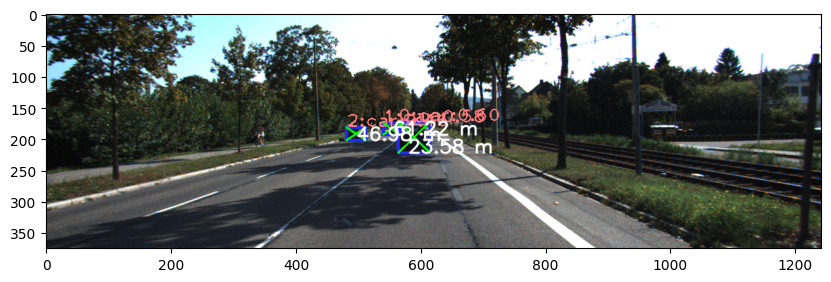

In [23]:
def addDepthToImage(img_ori, depth_list, pred_bboxes):
    img = img_ori.copy()
    
    for i, distance in enumerate(depth_list):
        x1 = int(pred_bboxes[i][0] - pred_bboxes[i][2]/2)
        x2 = int(pred_bboxes[i][0] + pred_bboxes[i][2]/2)
        y0 = int(pred_bboxes[i][1])
        y1 = int(pred_bboxes[i][1] - pred_bboxes[i][3]/2)
        y2 = int(pred_bboxes[i][1] + pred_bboxes[i][3]/2)
        cv2.line(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.line(img, (x2, y1), (x1, y2), (0,255,0), 2)
        
        text_color = (255,255,255)  #(210, 105, 30)  # (255,255,255)
        cv2.putText(img, 
                    f'{distance: .2f} m', 
                    (x1, y2), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    fontScale=1, 
                    color=text_color, 
                    thickness=2,
                    lineType=cv2.LINE_AA)
    return img


img_with_depth = addDepthToImage(img_with_prediction, depth_list, pred_bboxes)
plt.figure(figsize=(10,5))
plt.imshow(img_with_depth)


### 4.3. Check Accuracy of Depth Estimation

In [24]:
# Read a ground truth file of KITTI
def readObjectLabelFile(file_path):
    def read_line(line):
        params = line.split()
        print(f'params = {params}')
        label = {}
        label['type'] = params[0]
        label['truncated'] = float(params[1])  # 0.0=完全に写っている
        label['occluded'] = float(params[2])  # 0=遮蔽なし
        label['alpha'] = float(params[3])  # オブジェクトのYaw角(相対)
        label['bbox'] = [float(v) for v in params[4:8]]  # bbox [pixel]
        label['dim'] = [float(v) for v in params[8:11]] # height, width, length [m]
        label['loc'] = [float(v) for v in params[11:14]]  # x, y, z [m]
        label['rot_y'] = float(params[14])  # オブジェクトのYaw角(絶対)
        return label
    #
    labels = []
    #
    with open(file_path, 'r') as f:
        for line in f:
            labels.append(read_line(line))
    return labels

file_id = 7
file_paths_label_left = sorted(glob(f'{top_dir_object}/label_2/*.txt'))
file_path_label_left = file_paths_label_left[file_id]
print(file_path_label_left)
labels = readObjectLabelFile(file_path_label_left)

for label in labels:
    print(label)

./KITTI/object/training/label_2/000007.txt
params = ['Car', '0.00', '0', '-1.56', '564.62', '174.59', '616.43', '224.74', '1.61', '1.66', '3.20', '-0.69', '1.69', '25.01', '-1.59']
params = ['Car', '0.00', '0', '1.71', '481.59', '180.09', '512.55', '202.42', '1.40', '1.51', '3.70', '-7.43', '1.88', '47.55', '1.55']
params = ['Car', '0.00', '0', '1.64', '542.05', '175.55', '565.27', '193.79', '1.46', '1.66', '4.05', '-4.71', '1.71', '60.52', '1.56']
params = ['Cyclist', '0.00', '0', '1.89', '330.60', '176.09', '355.61', '213.60', '1.72', '0.50', '1.95', '-12.63', '1.88', '34.09', '1.54']
params = ['DontCare', '-1', '-1', '-10', '753.33', '164.32', '798.00', '186.74', '-1', '-1', '-1', '-1000', '-1000', '-1000', '-10']
params = ['DontCare', '-1', '-1', '-10', '738.50', '171.32', '753.27', '184.42', '-1', '-1', '-1', '-1000', '-1000', '-1000', '-10']
{'type': 'Car', 'truncated': 0.0, 'occluded': 0.0, 'alpha': -1.56, 'bbox': [564.62, 174.59, 616.43, 224.74], 'dim': [1.61, 1.66, 3.2], 'loc'

In [25]:
# Compair Estimation and Ground truth
def comparePredictionAndLabel(pred_bboxes, pred_classes, pred_depths, labels, ):
    label_depths = - np.ones((len(pred_bboxes,)))
    for i, (pred_bbox, pred_class, pred_depth) in enumerate(zip(pred_bboxes, pred_classes, pred_depths)):
        for label in labels:
            if label["type"].lower() == pred_class.lower():
                # pos of predition
                center_x = pred_bbox[0]
                center_y = pred_bbox[1]
                
                # if prediction pos is in the bbox of label, get depth info.
                if (label['bbox'][0] < center_x < label['bbox'][2] and 
                    label['bbox'][1] < center_y < label['bbox'][3]):
                    label_depths[i] = label['loc'][2]
            if label_depths[i] > 0:
                break
    return label_depths

label_depths = comparePredictionAndLabel(pred_bboxes, pred_classes, depth_list, labels)
depth_diff = np.array(depth_list) - label_depths
print(f'depth : ground truth  = {label_depths}')
print(f'depth : estimation    = {depth_list}')
print(f'depth diff            = {depth_diff}')
                       

depth : ground truth  = [      25.01       60.52       47.55]
depth : estimation    = [23.582333, 61.218784, 46.981857]
depth diff            = [    -1.4277     0.69878    -0.56814]


In [26]:
def objectDetectionPipeline(file_path_img_left, file_path_img_right, p_left, p_right, model, device):
    # Load images
    img_bgr_left = cv2.imread(file_path_img_left)
    img_bgr_right = cv2.imread(file_path_img_right)
    img_rgb_left = cv2.cvtColor(img_bgr_left, cv2.COLOR_BGR2RGB)
    
    # BGR to GRAY
    img_gray_left = cv2.cvtColor(img_bgr_left, cv2.COLOR_BGR2GRAY)
    img_gray_right = cv2.cvtColor(img_bgr_right, cv2.COLOR_BGR2GRAY)
    
    # Compute the diparity map
    disparity_map = calcDisparity(img_gray_left, 
                                  img_gray_right, 
                                  matcher="stereo_sgbm",
                                  num_disparities=112,
                                  block_size=5,
                                  window_size=7)
    normalized_disparity = cv2.normalize(disparity_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype("uint8")
    colormapped_disparity = cv2.applyColorMap(normalized_disparity, cv2.COLORMAP_JET)
    
    # Get the calibration parameters
    K_left, R_left, t_left, _, _, _, _ = cv2.decomposeProjectionMatrix(p_left)
    K_right, R_right, t_right, _, _, _, _ = cv2.decomposeProjectionMatrix(p_right)
    
    # Compute a Depth Mpa
    focal_length = K_left[0,0]
    baseline = abs(t_left[0] - t_right[0])
    depth_map = calcDepthMap(disparity_map.copy(), focal_length, baseline)
    
    # Detect objects in 2D
    pred_bboxes, pred_classes, pred_conf = detectObstacles(img_bgr_left, model, device)
    
    # Estimate Depth
    depth_list = findDistances(depth_map, pred_bboxes)
    
    # Add prediction results to the image
    img_with_pred = drawDetectedObstacles(pred_bboxes, pred_classes, pred_conf, img_rgb_left)
    img_with_pred = addDepthToImage(img_with_pred, depth_list, pred_bboxes)
    #
    disparity_with_pred = drawDetectedObstacles(pred_bboxes, pred_classes, pred_conf, colormapped_disparity)
    disparity_with_pred = addDepthToImage(disparity_with_pred, depth_list, pred_bboxes)
    
    # Stack 2 images
    # stacked_img = np.vstack([img_with_pred, disparity_with_pred])
    
    return (img_with_pred, disparity_with_pred, img_rgb_left, disparity_map)

img shape = (375, 1242, 3)


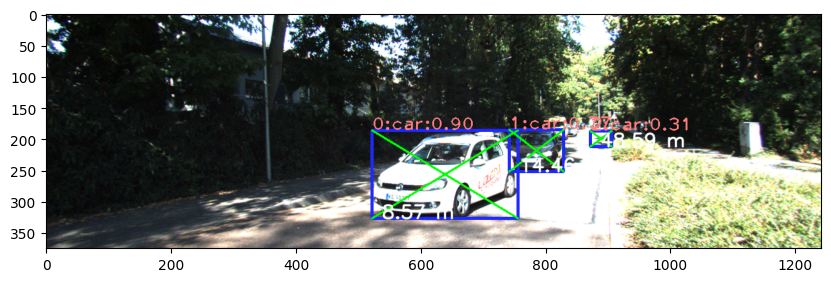

In [27]:
file_id = 7479
detection_res = objectDetectionPipeline(file_paths_img_left[file_id], 
                                        file_paths_img_right[file_id], 
                                        calib_params['P2'], 
                                        calib_params['P3'], 
                                        model, 
                                        device)
plt.figure(figsize=(10,5))
plt.imshow(detection_res[0])
plt.savefig(f'./output/stereo_depth_estimation_{file_id}.png')
print(f'img shape = {detection_res[2].shape}')

## 5. 3D Reconstruction
- With stereo camera images, we reconstruct 3D points.
- OpenCV uses the Q Matrix to get 3D point cloud.

$
Q = \begin{bmatrix}
1 & 0 & 0 & -c_x \\
0 & 1 & 0 & -c_y \\
0 & 0 & 0 & f \\
0 & 0 & -\frac{1}{T_x} & \frac{c_x - c'_x}{T_x}
\end{bmatrix}
$

- u, v :
    - 2D pose in the pixel coordinate
- d : 
    - disparity
- X, Y, Z, W : 
    - 3D pose in the homologous coordinate

$
Q \cdot \begin{bmatrix}
u \\
v \\
d \\
1
\end{bmatrix}
= \begin{bmatrix}
u - c_x \\
v - c_y \\
f \\
\frac{c_x - c'_x - d}{T_x}
\end{bmatrix}
= \begin{bmatrix}
X \\
Y \\
Z \\
W
\end{bmatrix}
$

- X', Y', Z' : 
    - 3D pose in the real-world coordinate

$
(X', Y', Z') = \left(\frac{X}{W}, \frac{Y}{W}, \frac{Z}{W}\right)
$

In [28]:
def calcQMatrix(K_left, K_right, R_stereo, t_stereo, img_size):
    # Init Q
    Q = np.zeros((4,4))
    
    # Calc Q
    cv2.stereoRectify(cameraMatrix1 = K_left,
                      cameraMatrix2 = K_right,
                      distCoeffs1= 0,
                      distCoeffs2=0,
                      imageSize=img_size,
                      R = R_stereo,
                      T = t_stereo,
                      R1 = None, R2 = None,
                      P1 = None, P2 = None, 
                      Q = Q)
    return Q

# According to KITTI configuration.
R_stereo = np.eye(3)
t_stereo = np.array([0.51, 0.0, 0.0])

# 
img_size = (detection_res[2].shape[1], detection_res[2].shape[0])
Q = calcQMatrix(K_left, K_right, R_stereo, t_stereo, img_size)

print(Q)
    

[[          1           0           0     -604.08]
 [          0           1           0     -180.51]
 [          0           0           0      707.05]
 [          0           0     -1.9608           0]]


In [29]:
def get3dPointsAndColors(disparity_map, Q, img_rgb):
    # Get 3D points
    points = cv2.reprojectImageTo3D(disparity_map.copy(), Q)
    
    # Reflect X axis
    reflext_matrix = np.identity(3)
    reflext_matrix[0] *= -1
    points = np.matmul(points, reflext_matrix)
    
    # Get colors for each points
    mask = (disparity_map > 0) & np.isfinite(disparity_map)    
    points = points[mask]
    colors = img_rgb[mask]
    colors = colors.reshape(-1,3)
    
    return points, colors

In [30]:
from stereo_camera_utility import write_ply

file_id = 7479
img_bgr_left = cv2.imread(file_paths_img_left[file_id])
img_bgr_right = cv2.imread(file_paths_img_right[file_id])
img_rgb_left = cv2.cvtColor(img_bgr_left, cv2.COLOR_BGR2RGB)
disparity_map = calcDisparity(cv2.cvtColor(img_bgr_left, cv2.COLOR_BGR2GRAY), 
                              cv2.cvtColor(img_bgr_right, cv2.COLOR_BGR2GRAY), 
                              matcher="stereo_sgbm",
                              num_disparities=112,
                              block_size=5,
                              window_size=7)
points3D, colors3D = get3dPointsAndColors(disparity_map, Q, img_rgb_left)
file_path_ply = './output/stereo_point_cloud.ply'
write_ply(file_path_ply, points3D, colors3D)

<ipython-input-29-454d943e1de2>:8: RuntimeWarning: invalid value encountered in matmul
  points = np.matmul(points, reflext_matrix)


In [31]:
import open3d as o3d
#from stereo_camera_utility import savePointCloudAsImage

def savePointCloudAsImage(pcd, file_path_save, width=1024, height=768):
    # Create the visualizer
    vis = o3d.visualization.Visualizer()
    
    if width is None or height is None:
        vis.create_window(visible=True)
    else:
        vis.create_window(visible=True, width=width, height=height) # vis.create_window(visible=False)
    #

    # Add geometry (e.g., point cloud)
    vis.add_geometry(pcd)
    vis.poll_events()
    vis.update_renderer()

    # Set the view parameters (camera settings)
    view_control = vis.get_view_control()
    view_control.set_zoom(0.01)
    view_control.set_front([0, 0.01, 5])
    view_control.set_lookat([0, 0.1, -10])
    view_control.set_up([0, 0, -1])

    # Alternative Camera Angle
    #view_control.set_front([ 0.27028868132726824, -0.0036027827686225091, 0.96277258410420508 ])
    #view_control.set_up([ -0.01446335938247148, 0.99986496068000874, 0.0078020279247221856 ])

    # Update the visualization to reflect changes
    vis.update_geometry(pcd)
    vis.poll_events()
    vis.update_renderer()

    # Save the screenshot
    vis.capture_screen_image(file_path_save)

    # Close the visualizer window
    vis.destroy_window()    

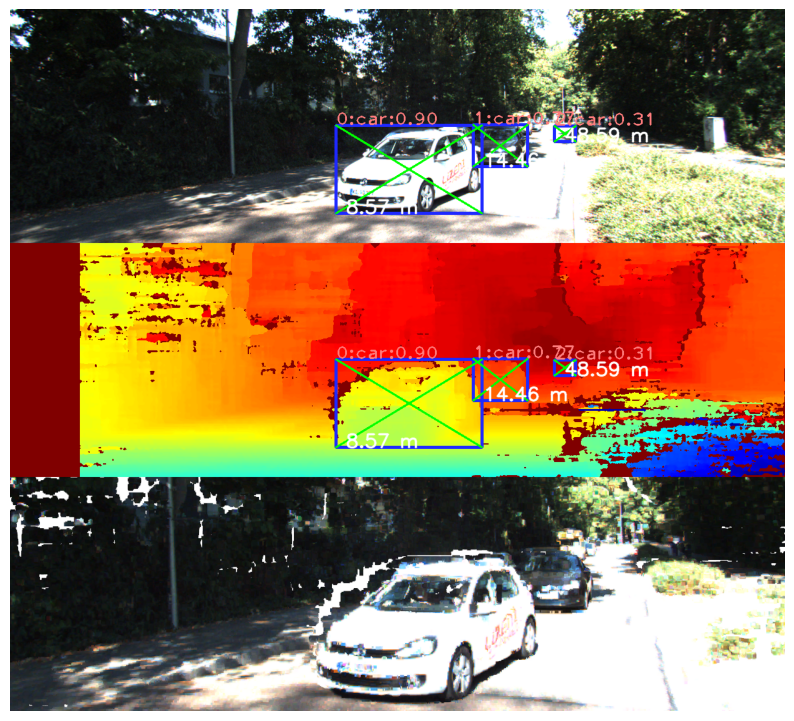

In [32]:
# Read ply File as pcd
pcd = o3d.io.read_point_cloud(file_path_ply)

# Save pcd as an image file
file_path_pcd_img = './output/stereo_point_cloud.png'
savePointCloudAsImage(pcd, file_path_pcd_img, width=1920, height=1016)

# Show point cloud
img_pcd = cv2.imread(file_path_pcd_img)
img_pcd = cv2.cvtColor(img_pcd, cv2.COLOR_BGR2RGB)

# Crop image
pcd_height, pcd_width = img_pcd.shape[:2]
target_width, target_height = img_size
y_offset = 80
y_min = max(int(pcd_height/2 - target_height/2), 0) + y_offset
y_max = y_min + target_height
x_min = max(int(pcd_width/2 - target_width/2), 0)
x_max = x_min + target_width
img_pcd_cropped = img_pcd[y_min:y_max, x_min:x_max, :]

# Stack images: RGB, Disparity, 3D-Point-Cloud
stacked_img = np.vstack([detection_res[0], detection_res[1], img_pcd_cropped])

plt.figure(figsize=(10,15))
plt.imshow(stacked_img)
plt.axis('off')
plt.savefig('./output/stereo_point_cloud_stacked.png', bbox_inches='tight', pad_inches=0)


In [37]:
def depthEstimationPipeline(file_path_img_left, file_path_img_right, file_id, p_left, p_right, Q, model, device):
    save_name_head = f'./output/stereo_pcd_{file_id: 03d}'
    
    # Detect Object and Get Depth
    # detect_res = (img_with_pred, disparity_with_pred, img_rgb_left, disparity_map)
    (img_with_pred, disparity_with_pred, img_rgb_left, disparity_map) = objectDetectionPipeline(
        file_path_img_left, file_path_img_right, p_left, p_right, model, device)
    
    # Create Point Cloud
    points3D, colors3D = get3dPointsAndColors(disparity_map, Q, img_rgb_left)
    file_path_ply = f'{save_name_head}.ply'
    write_ply(file_path_ply, points3D, colors3D)
    
    # Read ply File as pcd
    pcd = o3d.io.read_point_cloud(file_path_ply)

    # Save pcd as an image file
    file_path_pcd_img = f'{save_name_head}.png'
    savePointCloudAsImage(pcd, file_path_pcd_img, width=1920, height=1016)

    # load point cloud image
    img_pcd = cv2.imread(file_path_pcd_img)
    img_pcd = cv2.cvtColor(img_pcd, cv2.COLOR_BGR2RGB)

    # Crop image
    pcd_height, pcd_width = img_pcd.shape[:2]
    target_height, target_width = img_with_pred.shape[:2]
    y_offset = 80
    y_min = max(int(pcd_height/2 - target_height/2), 0) + y_offset
    y_max = y_min + target_height
    x_min = max(int(pcd_width/2 - target_width/2), 0)
    x_max = x_min + target_width
    img_pcd_cropped = img_pcd[y_min:y_max, x_min:x_max, :]

    # Stack images: RGB, Disparity, 3D-Point-Cloud
    stacked_img = np.vstack([img_with_pred, disparity_with_pred, img_pcd_cropped])
    
    return stacked_img

## 7. Video Depth Estimation
- Time series image files are stored in raw dataset.

In [34]:
import imageio
from tqdm import tqdm
from IPython.core.interactiveshell import InteractiveShell

In [35]:
# raw
top_dir_raw = './KITTI/raw_data/2011_09_30/2011_09_30_drive_0016_sync'
file_paths_raw_img_left = sorted(glob(f'{top_dir_raw}/image_02/data/*.png'))
file_paths_raw_img_right = sorted(glob(f'{top_dir_raw}/image_03/data/*.png'))

frames1 = []
max_frame = 250
do_resize = True

for file_id, (file_path_img_left, file_path_img_right) in tqdm(
        enumerate(zip(file_paths_raw_img_left, file_paths_raw_img_right)),
        total=len(file_paths_raw_img_left),
        desc="Generating GIF frames"):
    
    # Create 1-frame
    frame = depthEstimationPipeline(file_path_img_left, file_path_img_right, file_id, p_left, p_right, Q, model, device)
    
    # resize
    if do_resize:
        new_size = (int(frame.shape[0]/2), int(frame.shape[1]/2)  )
        frame = cv2.resize(frame, new_size)
    
    # save
    frames1.append(frame)
        
    if file_id > max_frame:
        break    

# save to file    
file_path_movie1 = './output/stereo_4d_perception_2011_09_30_drive_0016.gif'
imageio.mimsave(file_path_movie1, frames1, fps=10, loop=0)  # fpsは調整可能    

Generating GIF frames:   0%|          | 1/279 [00:02<13:04,  2.82s/it]<ipython-input-29-454d943e1de2>:8: RuntimeWarning: invalid value encountered in matmul
  points = np.matmul(points, reflext_matrix)
Generating GIF frames:  90%|████████▉ | 251/279 [11:27<01:16,  2.74s/it]


![4D Perception-1](./output/stereo_4d_perception_2011_09_30_drive_0016.gif)

In [36]:
# raw
top_dir_raw = './KITTI/raw_data/2011_10_03/2011_10_03_drive_0027_sync'
file_paths_raw_img_left = sorted(glob(f'{top_dir_raw}/image_02/data/*.png'))
file_paths_raw_img_right = sorted(glob(f'{top_dir_raw}/image_03/data/*.png'))

frames2 = []
max_frame = 250
do_resize = True

for file_id, (file_path_img_left, file_path_img_right) in tqdm(
        enumerate(zip(file_paths_raw_img_left, file_paths_raw_img_right)),
        total=len(file_paths_raw_img_left),
        desc="Generating GIF frames"):
    
    # Create 1-frame
    frame = depthEstimationPipeline(file_path_img_left, file_path_img_right, file_id, p_left, p_right, Q, model, device)
    
    # resize
    if do_resize:
        new_size = (int(frame.shape[0]/2), int(frame.shape[1]/2)  )
        frame = cv2.resize(frame, new_size)
    
    # save
    frames2.append(frame)
        
    if file_id > max_frame:
        break    

# save to file    
file_path_movie2 = './output/stereo_4d_perception_2011_10_03_drive_0027.gif'
imageio.mimsave(file_path_movie2, frames2, fps=10, loop=0)  # fpsは調整可能    

Generating GIF frames:   0%|          | 0/4544 [00:00<?, ?it/s]<ipython-input-29-454d943e1de2>:8: RuntimeWarning: invalid value encountered in matmul
  points = np.matmul(points, reflext_matrix)
Generating GIF frames:   6%|▌         | 251/4544 [11:46<3:21:29,  2.82s/it]


![4D Perception-2](./output/stereo_4d_perception_2011_10_03_drive_0027.gif)